
## Tuyere model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD tuyere data with 894 samples

## Web application 5 inputs and 2 outputs

Run interactively on the web at:

## Inputs


(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

(9, 'i_hot_blast_temp_k')

## Outputs

(14, 'o_tuyere_exit_velo_m_s')

(15, 'o_tuyere_t_k')


In [1]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [2]:
import PDFshapingUtils as PDF_tk

In [3]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()


In [4]:

PDFshapingOBJ.initializeImpulseGaussian()

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([4000])
torch.Size([4000])
tensor(100.0000)


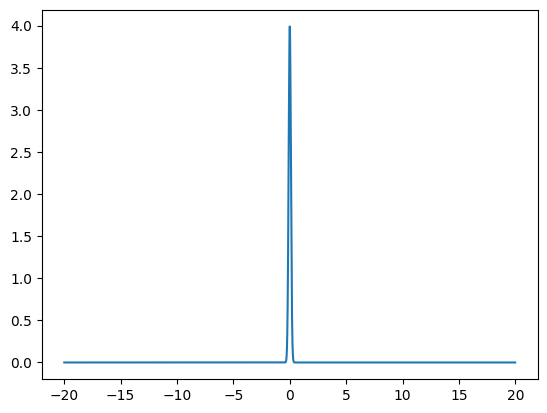

In [5]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## RUN KDE test

In [6]:
## PDFshapingOBJ.test_torchKDE_with_fake_data()

## Load Data

In [7]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.11.2023.csv')


In [8]:

PDFshapingOBJ.CFD_raw_data


,index,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_bf_windrate_nm3_hr,i_hb_moist_g_nm3,i_hot_blast_press_pa,i_hot_blast_temp_k,...,o_shaft_co_utiliz,o_shaft_h2_utiliz,o_shaft_top_gas_temp_c,o_shaft_press_drop_pa,o_shaft_coke_rate_kg_thm,o_shaft_cohesive_zone_tip_height_m,o_shaft_co_v_perc,o_shaft_co2_v_perc,o_shaft_h2_v_perce,o_shaft_n2_v_perc
0,1,0,0,37.9,300,21,308750.365,12.154,359906.3,1459.817,...,47.20085,42.99392,118.8785,108434.33,462.73655,31.83963,0.217192,0.194163,0.043833,0.544812
1,2,0,0,37.9,300,24,308750.365,12.154,359906.3,1459.817,...,49.15851,44.99764,95.7563,108381.02,480.82105,31.83963,0.226098,0.218613,0.040343,0.514946
2,3,0,0,37.9,300,27,308750.365,12.154,359906.3,1459.817,...,49.30602,44.48147,84.8519,112232.83,500.10050,31.75963,0.241959,0.235334,0.037726,0.484981
3,4,0,0,37.9,300,30,308750.365,12.154,359906.3,1459.817,...,47.22992,46.37194,66.3779,118634.40,521.58650,31.55962,0.267702,0.239597,0.035448,0.457252
4,5,0,0,70.0,300,21,308750.365,12.154,359906.3,1459.817,...,46.66340,41.83302,130.4139,106947.64,422.57185,31.75963,0.211014,0.184613,0.071127,0.533246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,890,20,0,70.0,300,27,308750.365,12.154,359906.3,1459.817,...,48.11546,42.78430,122.0079,137423.80,421.58995,31.80024,0.213421,0.197917,0.122270,0.466392
890,891,30,0,60.0,300,27,308750.365,12.154,359906.3,1459.817,...,47.40511,41.99833,132.4238,146622.00,419.73570,31.88024,0.209051,0.188423,0.143751,0.458775
891,892,10,0,100.0,300,27,308750.365,12.154,359906.3,1459.817,...,48.24004,41.11932,121.1668,128838.00,409.45505,31.80024,0.216270,0.201562,0.117991,0.464177
892,893,20,0,90.0,300,27,308750.365,12.154,359906.3,1459.817,...,47.21544,39.43614,129.2255,129115.30,410.35835,31.76024,0.213118,0.190633,0.142068,0.454181


In [9]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
30
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_bf_windrate_nm3_hr')
(7, 'i_hb_moist_g_nm3')
(8, 'i_hot_blast_press_pa')
(9, 'i_hot_blast_temp_k')
(10, 'i_ore_moisture_weight_perce')
(11, 'i_coke_weight_kg')
(12, 

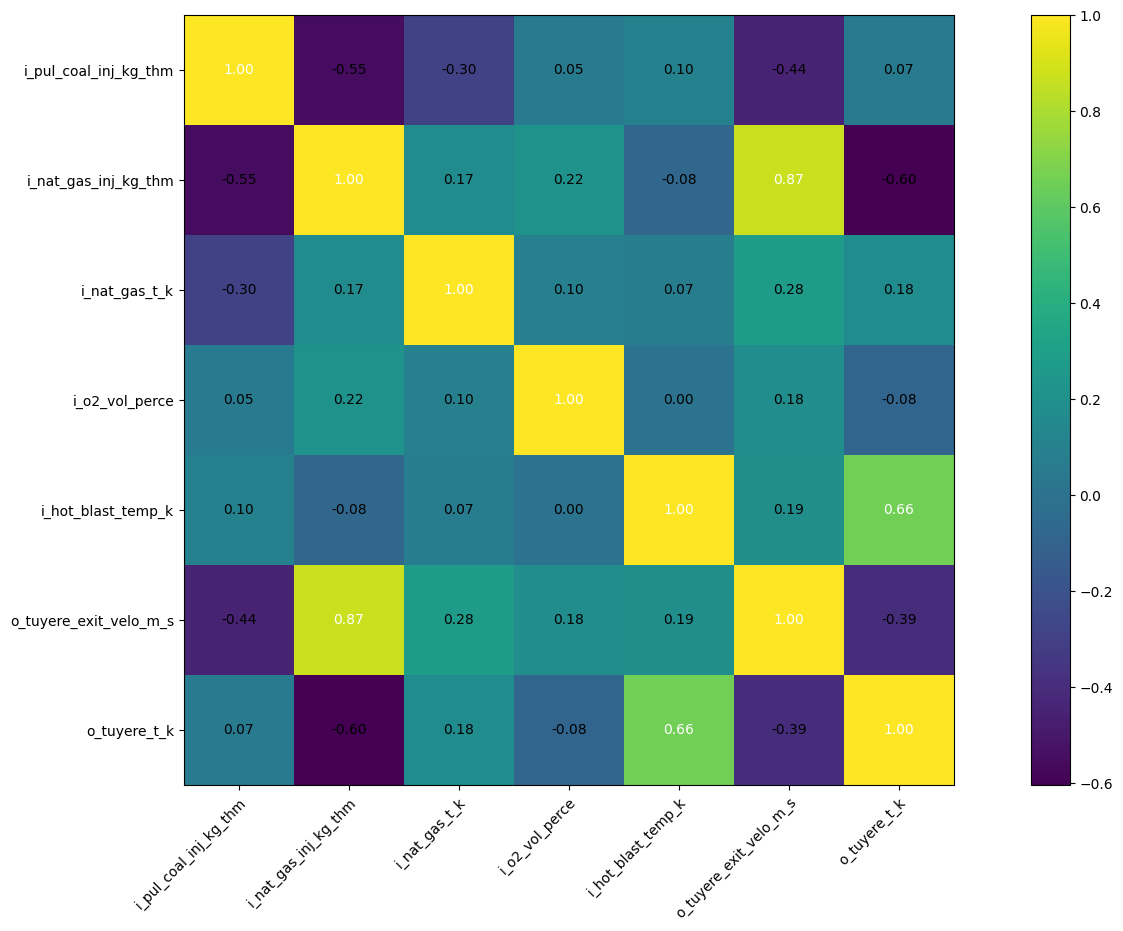

In [10]:

PDFshapingOBJ.list_of_selected_column_names = [ 'i_pul_coal_inj_kg_thm', 
                'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k',
                'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k']

PDFshapingOBJ.print_correlation_coefficients()


In [11]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.          10.           0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.          20.           0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.          30.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 30)



## Select inputs and outputs


In [12]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[ 2, 3, 4, 5, 9], 
                   outputs=[14, 15]   
)


5
2


In [13]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(894, 5)
(894, 2)


In [14]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [15]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 5)
(179, 5)
(715, 2)
(179, 2)


In [16]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [17]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [18]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [19]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 2) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(5, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      


In [20]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(5, 2)       
        
        ## F2
        self.f2_linear1 = nn.Linear(5, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 2)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [21]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [22]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "tuyere"


0  loss=  tensor(1.3848, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1196, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0747, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0180, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0269, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0271, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0265, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0247, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0119, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0109, grad_fn=<MseLossBackward0>)


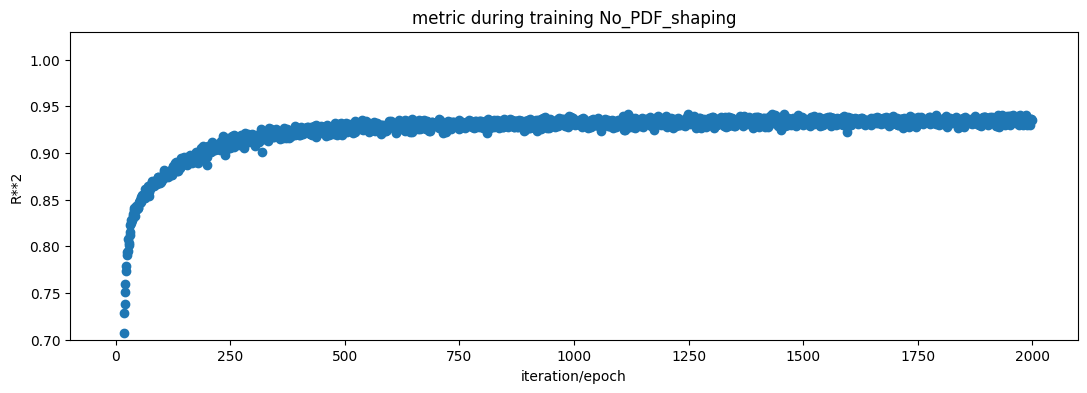

Training loss: tensor(0.0603, grad_fn=<MseLossBackward0>)
Training R**2: 0.9332884336800547
Test loss - scaled: tensor(0.0968, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(20.7733, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9065767392722865
Testing R**2 - descaled: 0.906576740423376
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.8576374789518615
*****
*****
Testing R**2 - Output: 1 o_tuyere_t_k 0.9555160012282736


In [23]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [24]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(141.34877, 141.70135)
(1394.3379, 1392.966)
**************************************************
preds, real
(143.72905, 143.07054)
(1328.6836, 1321.8584)
**************************************************
preds, real
(132.65428, 132.62503)
(1415.3274, 1425.9335)
**************************************************
preds, real
(133.61113, 132.47691)
(1366.293, 1365.9685)
**************************************************
preds, real
(129.14723, 129.80739)
(1425.8545, 1420.4083)
**************************************************
preds, real
(137.49321, 136.86153)
(1433.3622, 1431.8873)
**************************************************
preds, real
(138.36935, 138.02988)
(1424.4504, 1423.7987)
**************************************************
preds, real
(139.73692, 139.06866)
(1442.5562, 1444.6963)
**************************************************
preds, real
(136.44473, 135.68008)
(1427.9174, 1427.8629)
*********************

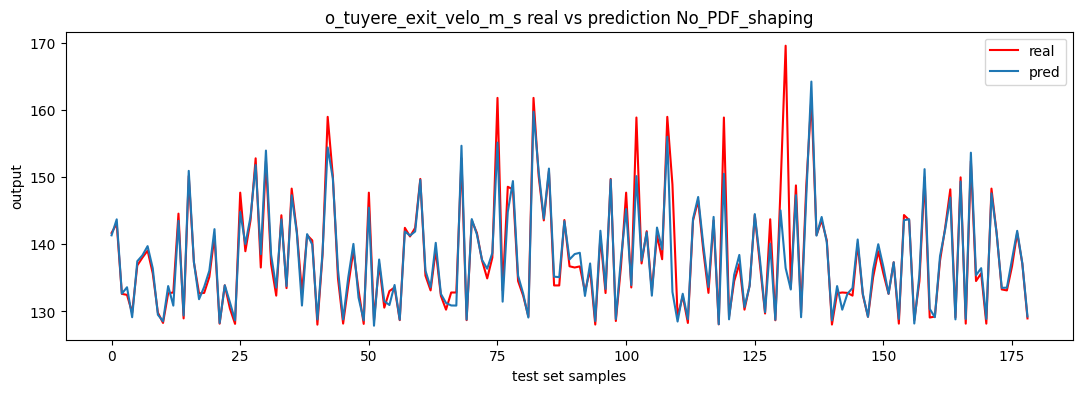

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


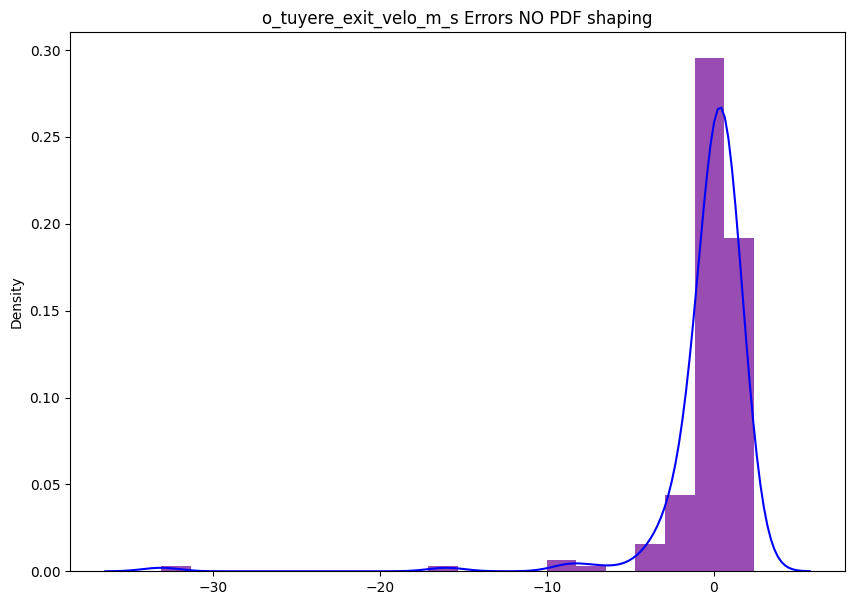

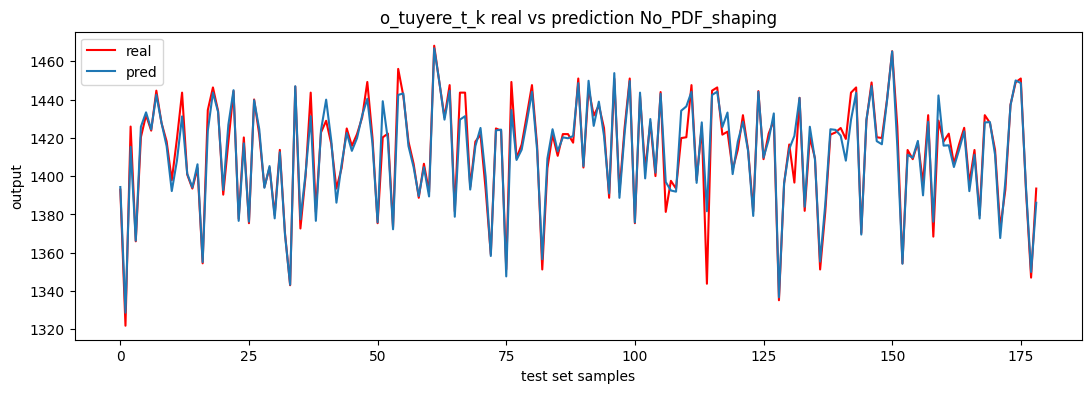

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


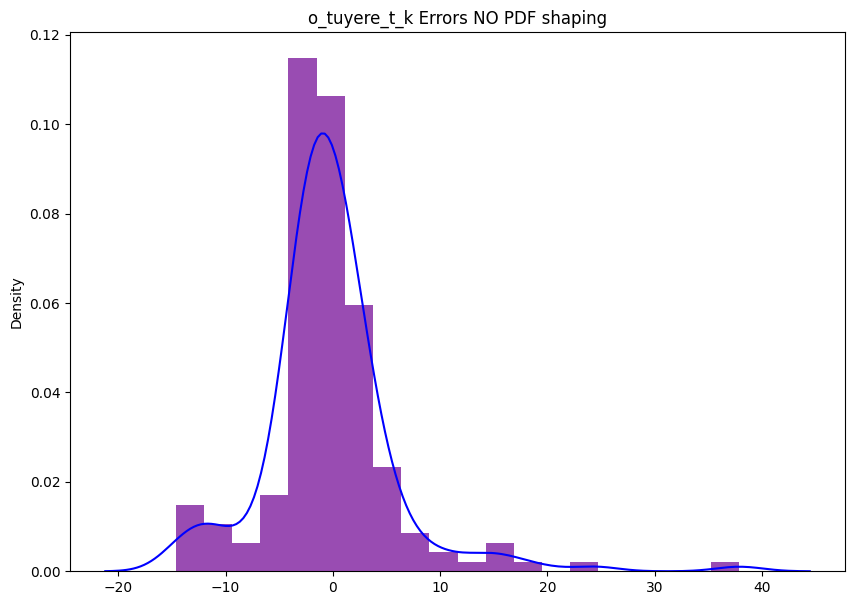

In [25]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [29]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
      
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
       
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 894  x 2
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )             ## 4000 x 2
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 2

        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        

        print(epoch, " loss= ", loss)
        if epoch % 50 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    




In [30]:

PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "tuyere"

PDFshapingOBJ.N_EPOCHS             = 2000
PDFshapingOBJ.N_EPOCHS_PDF         = 2000


0  loss=  tensor(0.5604, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.0922, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0338, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0542, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0210, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0687, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0608, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0301, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0081, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0209, grad_fn=<MseLossBackward0>)
0  loss=  tensor(0.0244, grad_fn=<MeanBackward0>)
torch.Size([715, 2])
torch.Size([4000, 2])


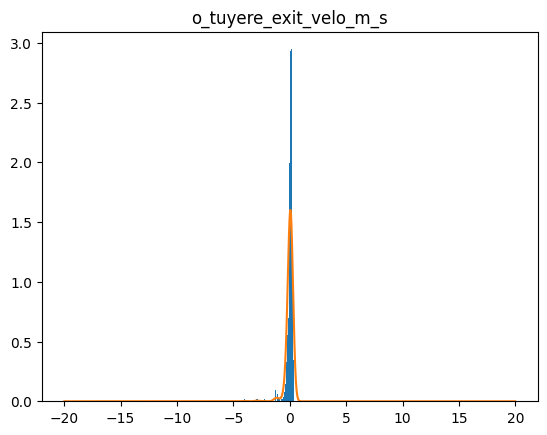

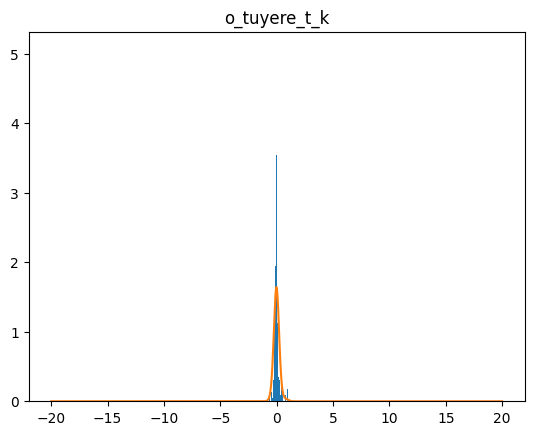

torch.Size([4000])
1  loss=  tensor(0.0250, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.0245, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.0245, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.0247, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.0250, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.0246, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.0243, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.0248, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.0248, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.0244, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.0244, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.0246, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.0246, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.0246, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.0248, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.0247, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.0244, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.0242, grad_fn=<MeanBackward0>)
19  loss=  tensor(0.0244, grad_fn=<MeanBackward0>)
20  loss=  tensor(0.0

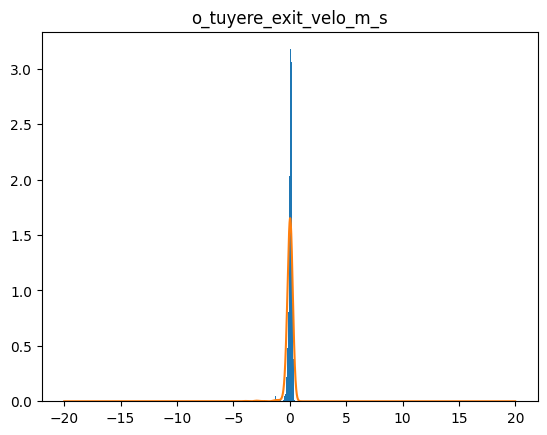

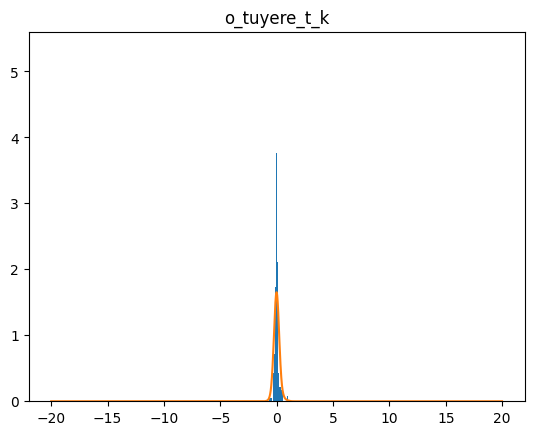

torch.Size([4000])
51  loss=  tensor(0.0240, grad_fn=<MeanBackward0>)
52  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
53  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
54  loss=  tensor(0.0239, grad_fn=<MeanBackward0>)
55  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
56  loss=  tensor(0.0238, grad_fn=<MeanBackward0>)
57  loss=  tensor(0.0240, grad_fn=<MeanBackward0>)
58  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
59  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
60  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
61  loss=  tensor(0.0237, grad_fn=<MeanBackward0>)
62  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
63  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
64  loss=  tensor(0.0239, grad_fn=<MeanBackward0>)
65  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
66  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
67  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
68  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
69  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
70  loss=  t

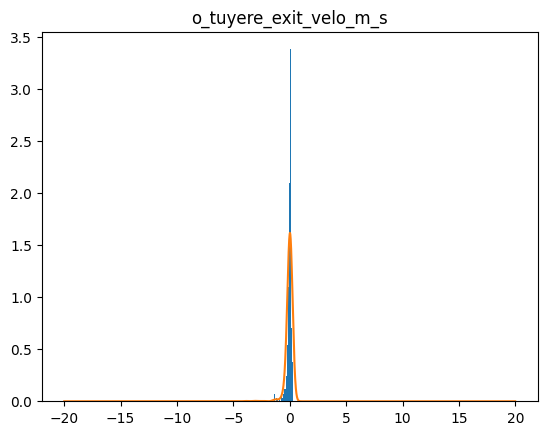

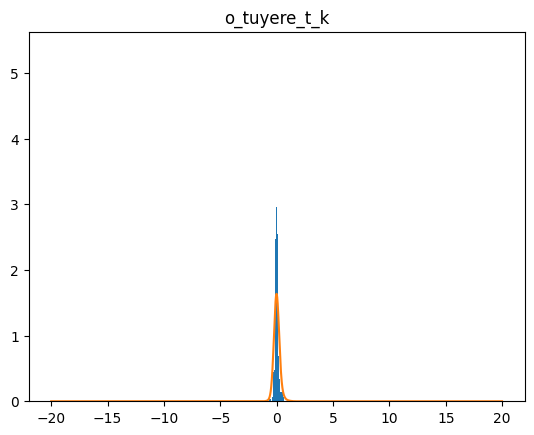

torch.Size([4000])
101  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
102  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
103  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
104  loss=  tensor(0.0237, grad_fn=<MeanBackward0>)
105  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
106  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
107  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
108  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
109  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
110  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
111  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
112  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
113  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
114  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
115  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
116  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
117  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
118  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
119  loss=  tensor(0.0235, grad_fn=<MeanBackw

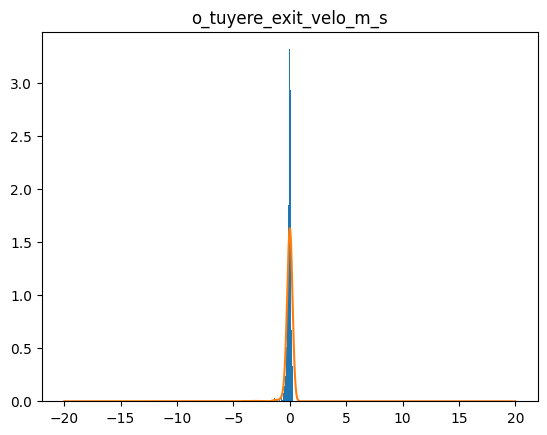

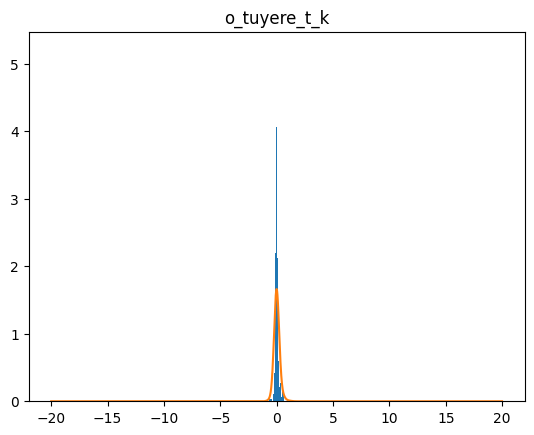

torch.Size([4000])
151  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
152  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
153  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
154  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
155  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
156  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
157  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
158  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
159  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
160  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
161  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
162  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
163  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
164  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
165  loss=  tensor(0.0237, grad_fn=<MeanBackward0>)
166  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
167  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
168  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
169  loss=  tensor(0.0236, grad_fn=<MeanBackw

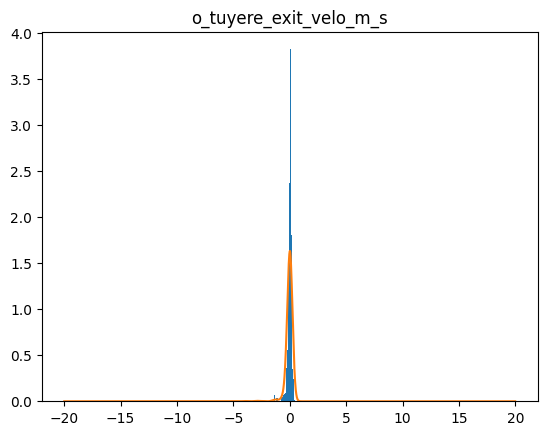

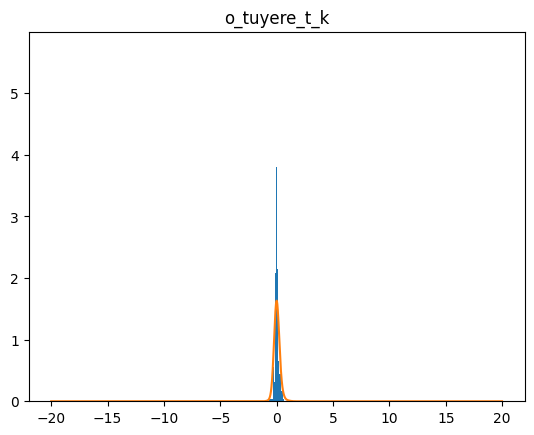

torch.Size([4000])
201  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.0238, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
219  loss=  tensor(0.0230, grad_fn=<MeanBackw

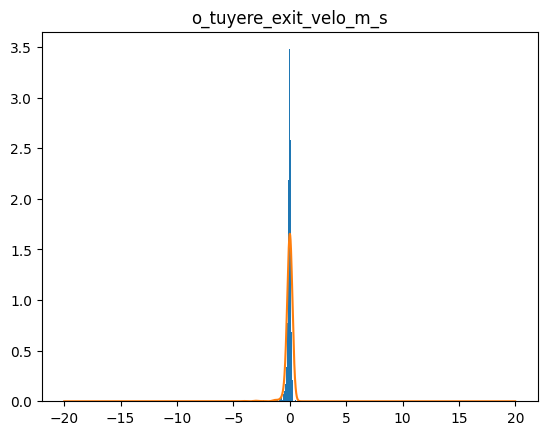

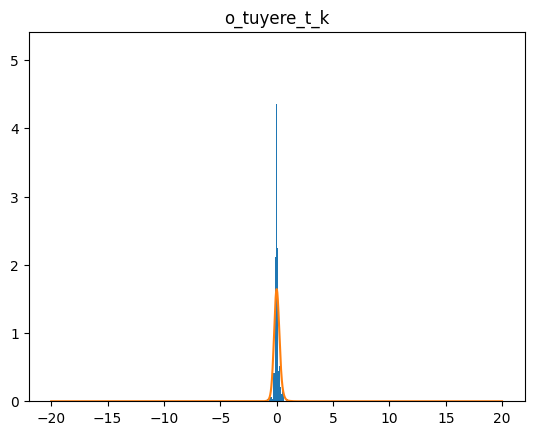

torch.Size([4000])
251  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
252  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
253  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
254  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
255  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
256  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
257  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
258  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
259  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
260  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
261  loss=  tensor(0.0234, grad_fn=<MeanBackward0>)
262  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
263  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
264  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
265  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
266  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
267  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
268  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
269  loss=  tensor(0.0230, grad_fn=<MeanBackw

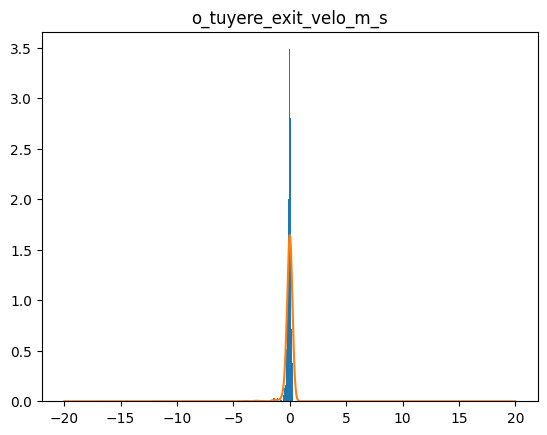

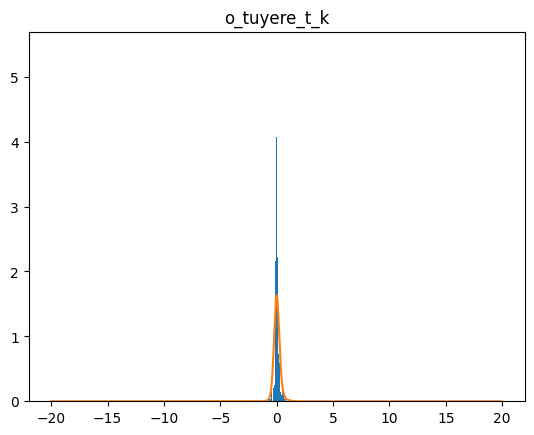

torch.Size([4000])
301  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
302  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
303  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
304  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
305  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
306  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
307  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
308  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
309  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
310  loss=  tensor(0.0235, grad_fn=<MeanBackward0>)
311  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
312  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
313  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
314  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
315  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
316  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
317  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
318  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
319  loss=  tensor(0.0230, grad_fn=<MeanBackw

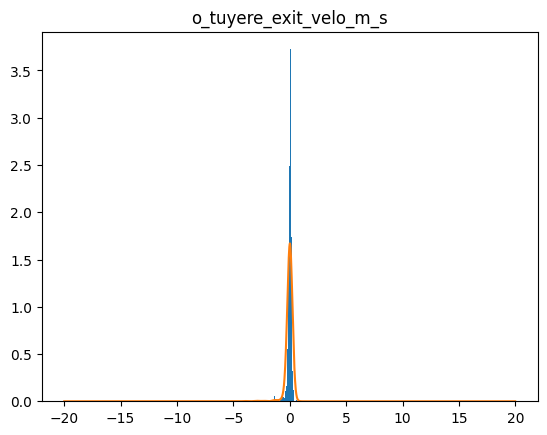

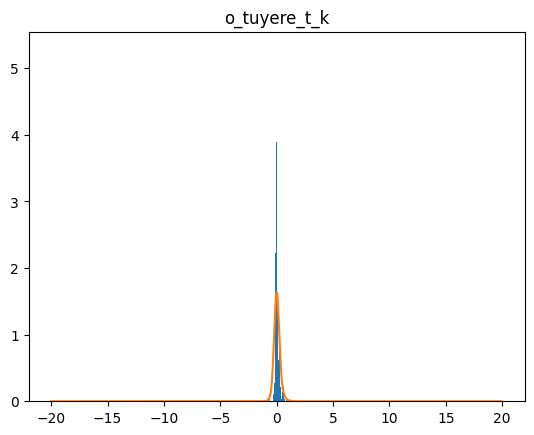

torch.Size([4000])
351  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
352  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
353  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
354  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
355  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
356  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
357  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
358  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
359  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
360  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
361  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
362  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
363  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
364  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
365  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
366  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
367  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
368  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
369  loss=  tensor(0.0226, grad_fn=<MeanBackw

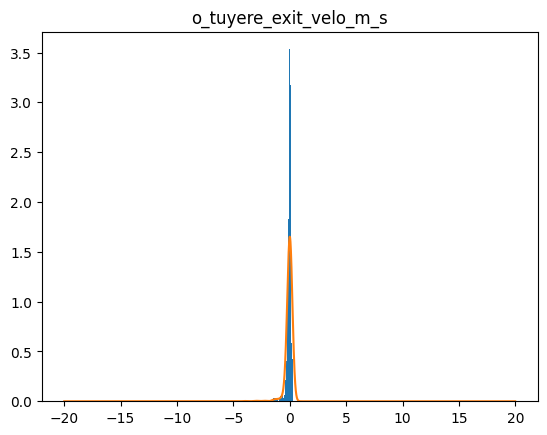

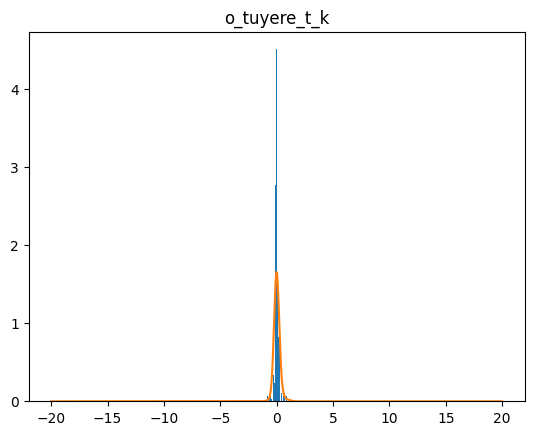

torch.Size([4000])
401  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
419  loss=  tensor(0.0231, grad_fn=<MeanBackw

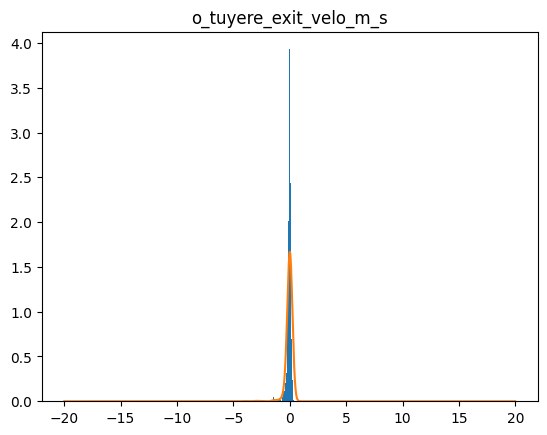

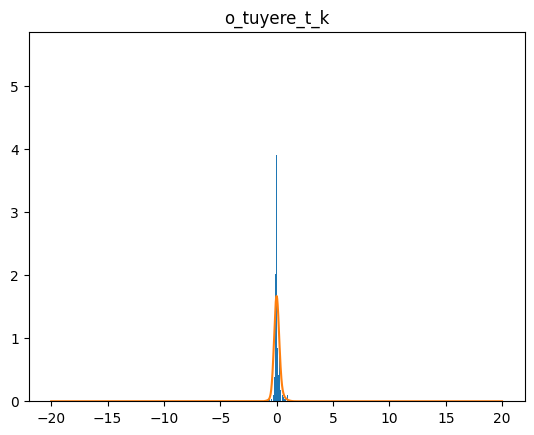

torch.Size([4000])
451  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
452  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
453  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
454  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
455  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
456  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
457  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
458  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
459  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
460  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
461  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
462  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
463  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
464  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
465  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
466  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
467  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
468  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
469  loss=  tensor(0.0229, grad_fn=<MeanBackw

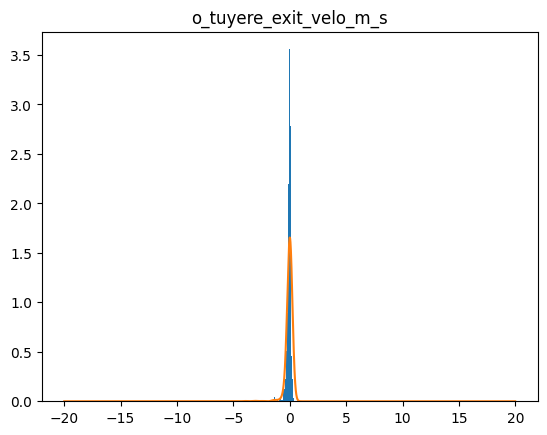

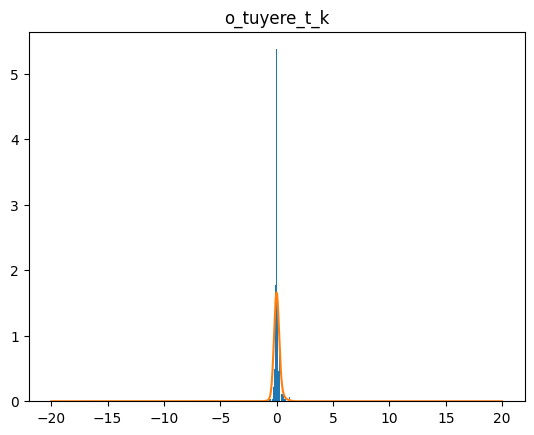

torch.Size([4000])
501  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
502  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
503  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
504  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
505  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
506  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
507  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
508  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
509  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
510  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
511  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
512  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
513  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
514  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
515  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
516  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
517  loss=  tensor(0.0233, grad_fn=<MeanBackward0>)
518  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
519  loss=  tensor(0.0225, grad_fn=<MeanBackw

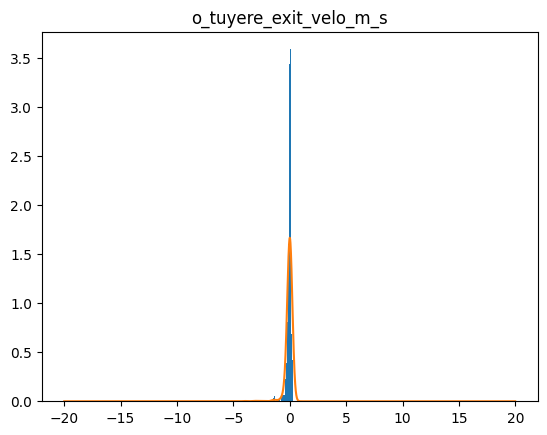

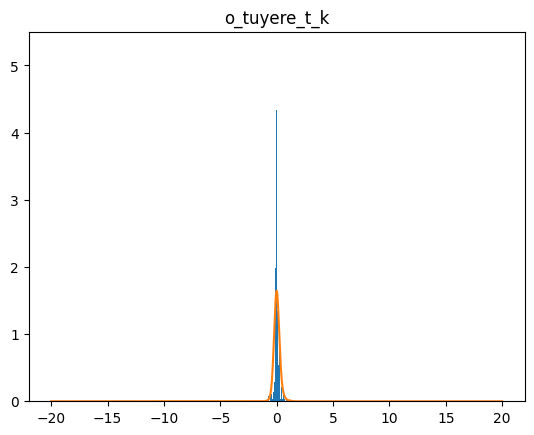

torch.Size([4000])
551  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
552  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
553  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
554  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
555  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
556  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
557  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
558  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
559  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
560  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
569  loss=  tensor(0.0231, grad_fn=<MeanBackw

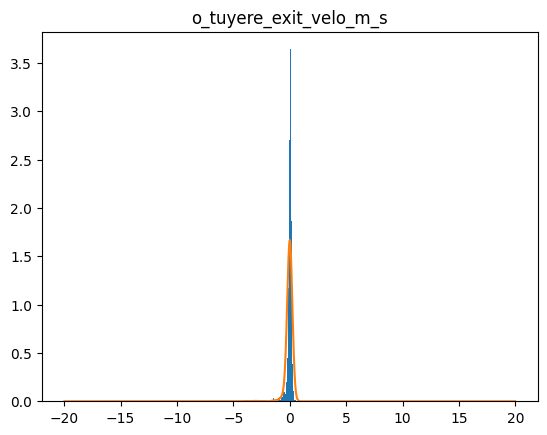

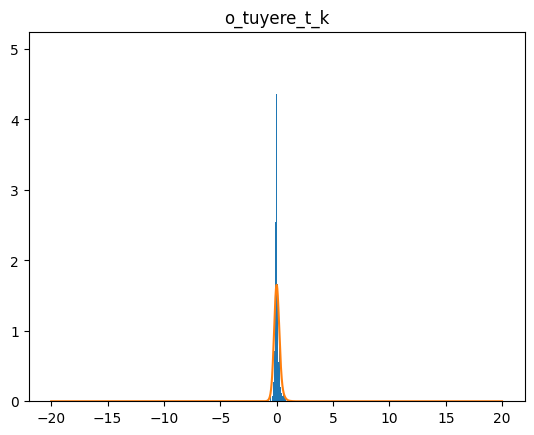

torch.Size([4000])
601  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
619  loss=  tensor(0.0228, grad_fn=<MeanBackw

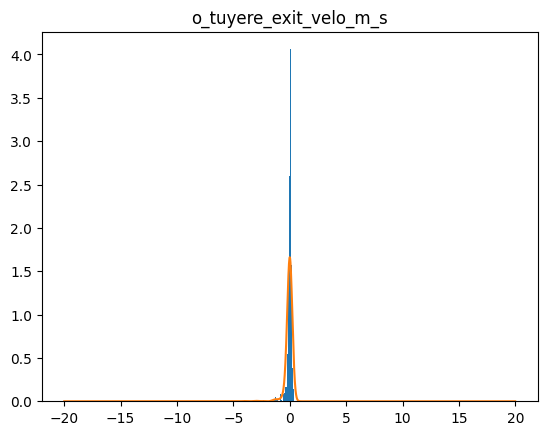

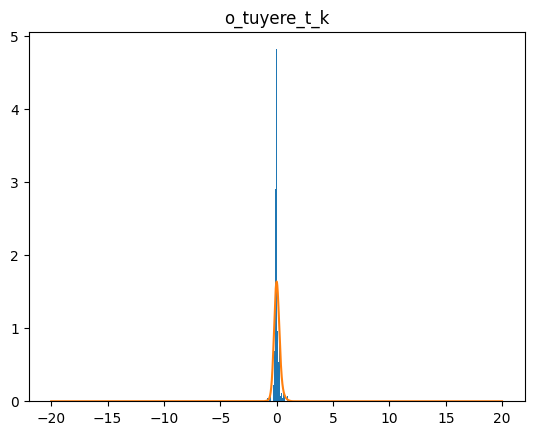

torch.Size([4000])
651  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
652  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
653  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
654  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
655  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
656  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
657  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
658  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
659  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
660  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
661  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
662  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
663  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
664  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
665  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
666  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
667  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
668  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
669  loss=  tensor(0.0230, grad_fn=<MeanBackw

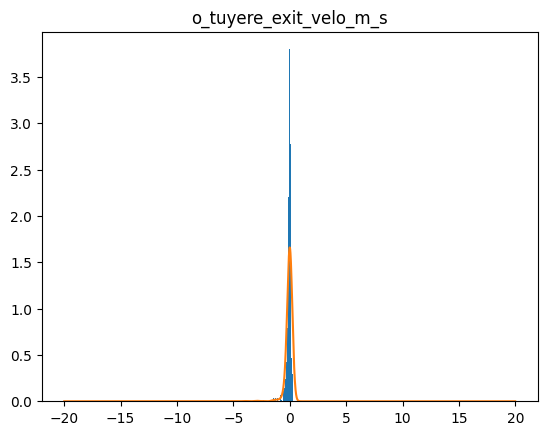

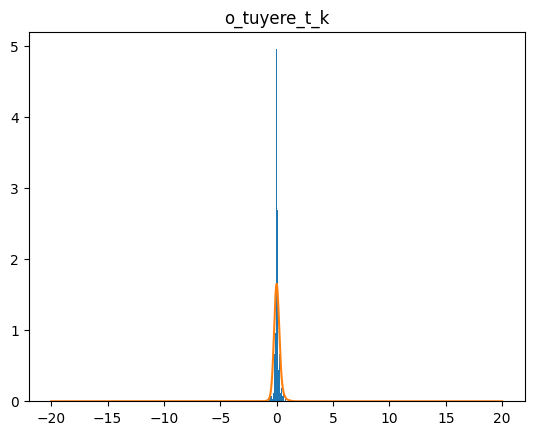

torch.Size([4000])
701  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
702  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
703  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
704  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
705  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
706  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
707  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
708  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
709  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
710  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
711  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
712  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
713  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
714  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
715  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
716  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
717  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
718  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
719  loss=  tensor(0.0229, grad_fn=<MeanBackw

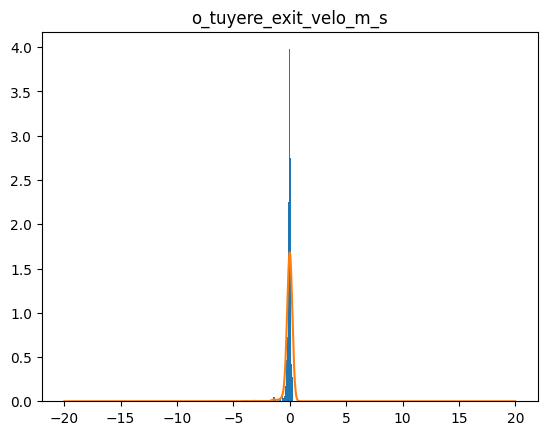

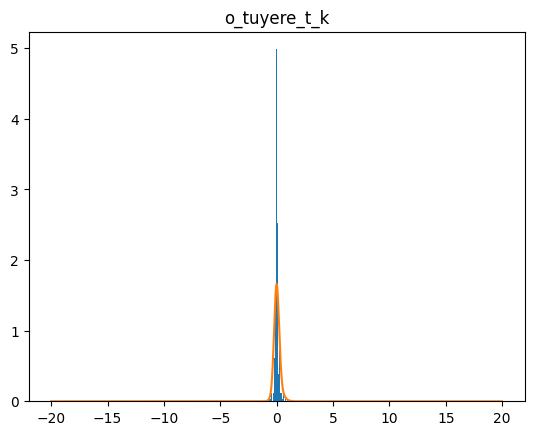

torch.Size([4000])
751  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
752  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
753  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
754  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
755  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
756  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
757  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
758  loss=  tensor(0.0231, grad_fn=<MeanBackward0>)
759  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
760  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
761  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
762  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
763  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
764  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
765  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
766  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
769  loss=  tensor(0.0228, grad_fn=<MeanBackw

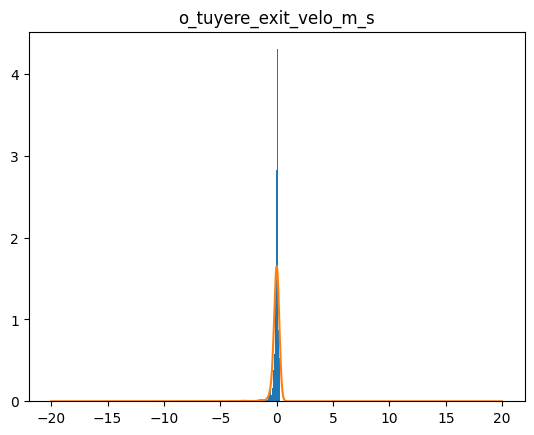

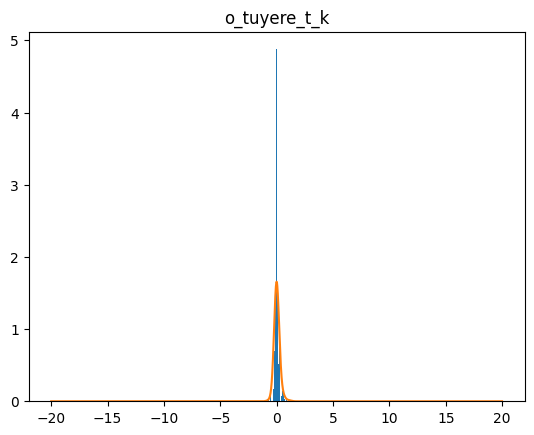

torch.Size([4000])
801  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.0232, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
819  loss=  tensor(0.0229, grad_fn=<MeanBackw

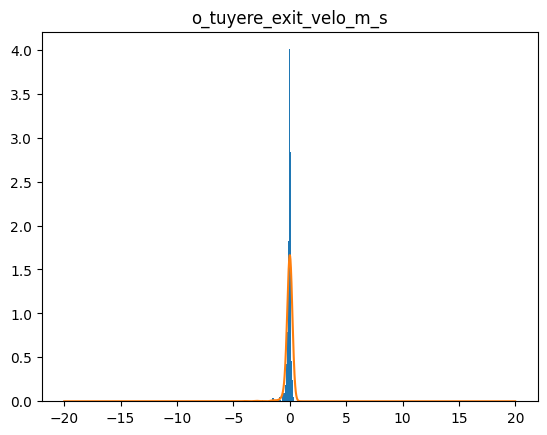

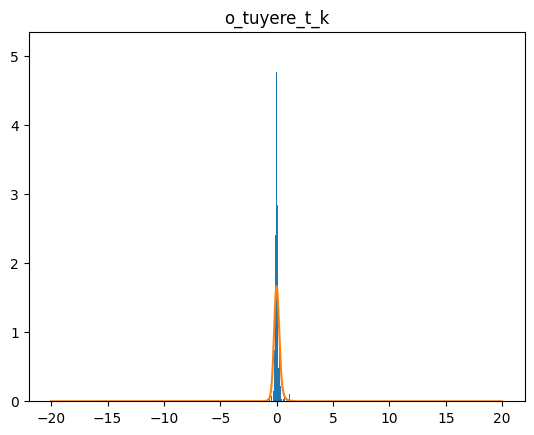

torch.Size([4000])
851  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
852  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
853  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
854  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
855  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
856  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
857  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
858  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
859  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
860  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
861  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
862  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
863  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
864  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
865  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
866  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
867  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
868  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
869  loss=  tensor(0.0222, grad_fn=<MeanBackw

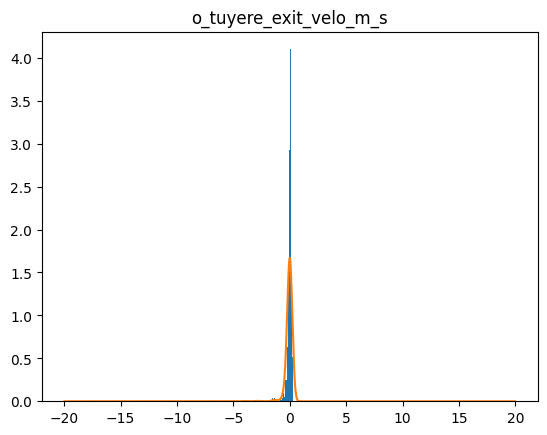

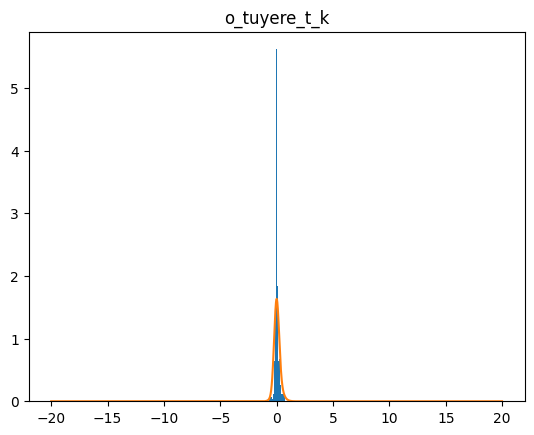

torch.Size([4000])
901  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
902  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
903  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
904  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
905  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
906  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
907  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
908  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
909  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
910  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
911  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
912  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
913  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
914  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
915  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
916  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
917  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
918  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
919  loss=  tensor(0.0225, grad_fn=<MeanBackw

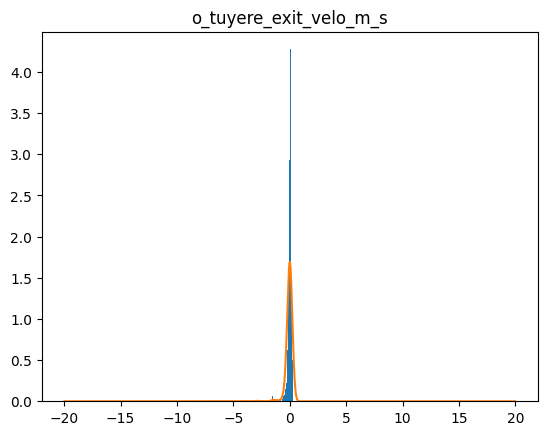

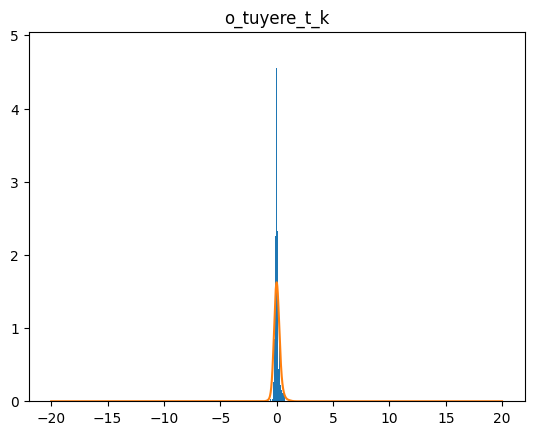

torch.Size([4000])
951  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
952  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
953  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
954  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
955  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
956  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
957  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
958  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
959  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
960  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
969  loss=  tensor(0.0228, grad_fn=<MeanBackw

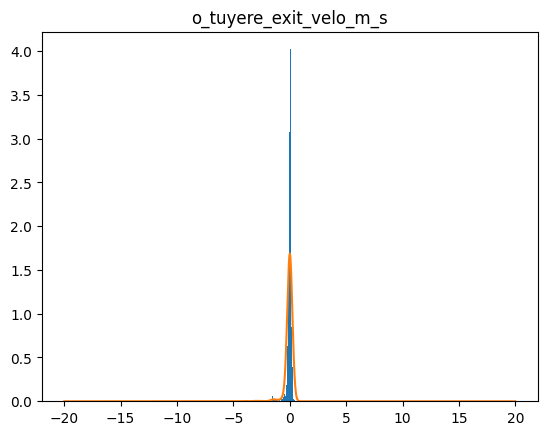

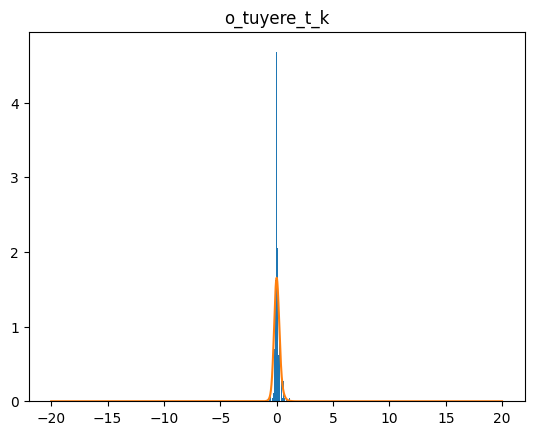

torch.Size([4000])
1001  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1002  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1003  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1004  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1005  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1006  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1007  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1008  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1009  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1010  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1011  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1012  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1013  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1014  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1015  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1016  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1017  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1018  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1019  loss=  tensor(0.0222,

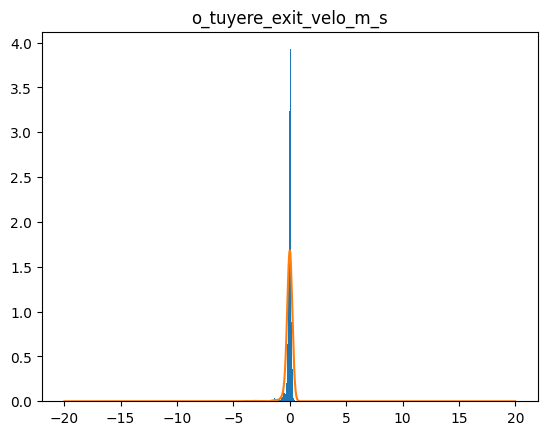

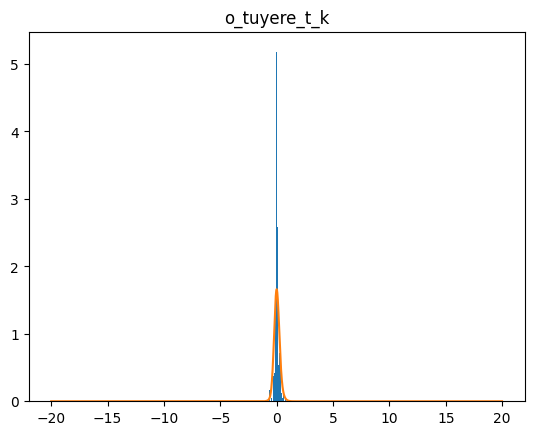

torch.Size([4000])
1051  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1052  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1053  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1054  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1055  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1056  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1057  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1058  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1059  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1060  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1061  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1062  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1063  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1064  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1065  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1066  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1067  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1068  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1069  loss=  tensor(0.0223,

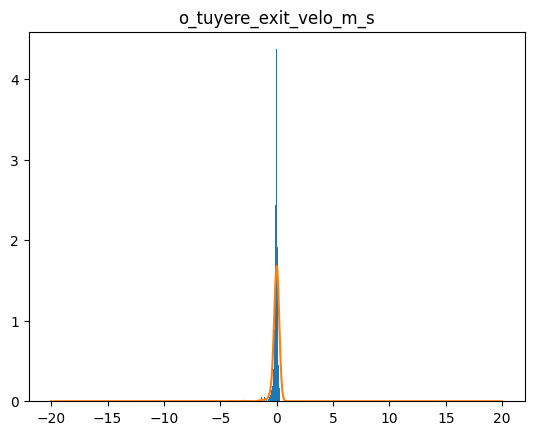

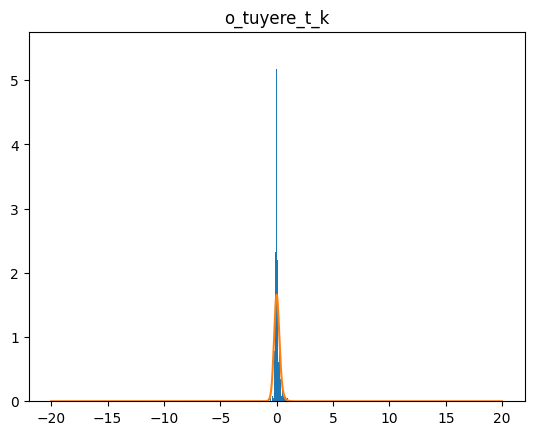

torch.Size([4000])
1101  loss=  tensor(0.0230, grad_fn=<MeanBackward0>)
1102  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1103  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1104  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1105  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1106  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1107  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1108  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1109  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1110  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1111  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1112  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1113  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1114  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1115  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1116  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1117  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1118  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1119  loss=  tensor(0.0227,

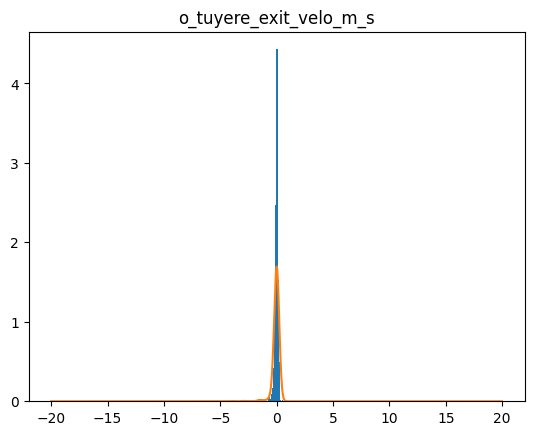

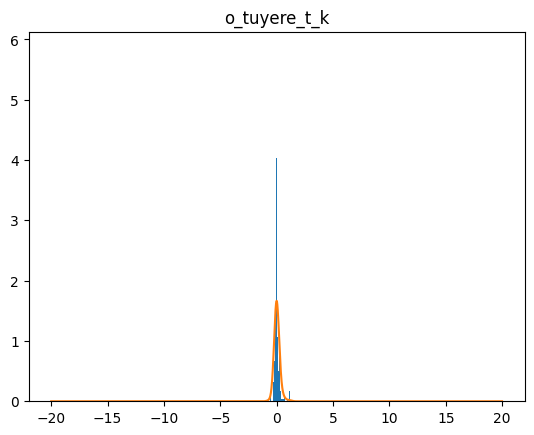

torch.Size([4000])
1151  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1152  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1153  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1154  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1155  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1156  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1157  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1158  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1159  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1160  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1161  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1162  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1163  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1164  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1165  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1166  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1167  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1168  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1169  loss=  tensor(0.0228,

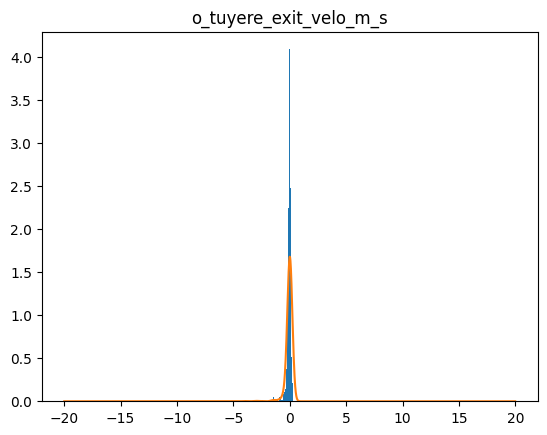

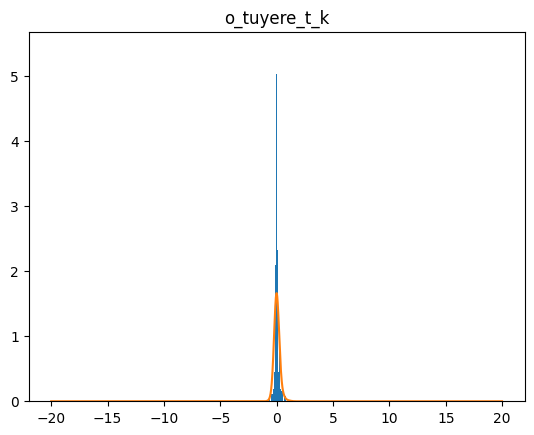

torch.Size([4000])
1201  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1202  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1203  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1204  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1205  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1206  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1207  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1208  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1209  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1210  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1211  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1212  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1213  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1214  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1215  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1216  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1217  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1218  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1219  loss=  tensor(0.0224,

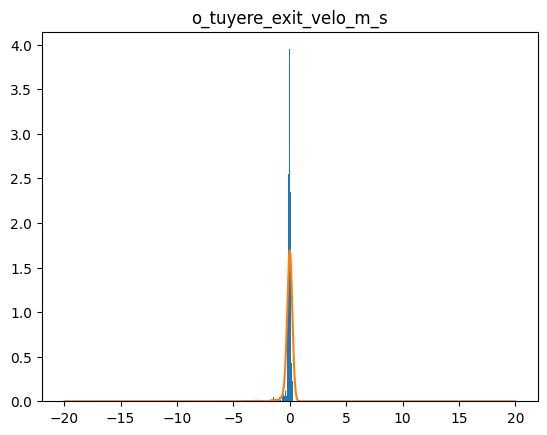

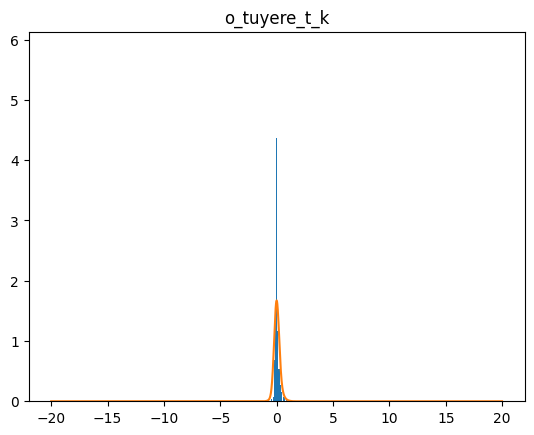

torch.Size([4000])
1251  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1252  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1253  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1254  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1255  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1256  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1257  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1258  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1259  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1260  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1261  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1262  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1263  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1264  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1265  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1266  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1267  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1268  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1269  loss=  tensor(0.0222,

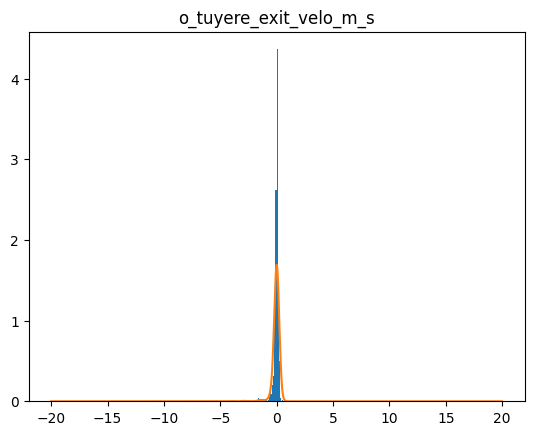

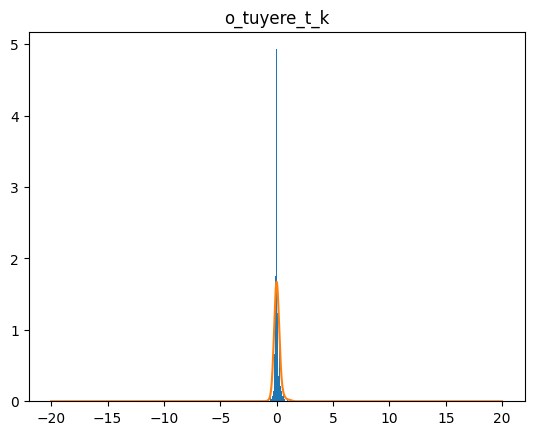

torch.Size([4000])
1301  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1302  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1303  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1304  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1305  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1306  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1307  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1308  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1309  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1310  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1311  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1312  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1313  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1314  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1315  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1316  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1317  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1318  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1319  loss=  tensor(0.0227,

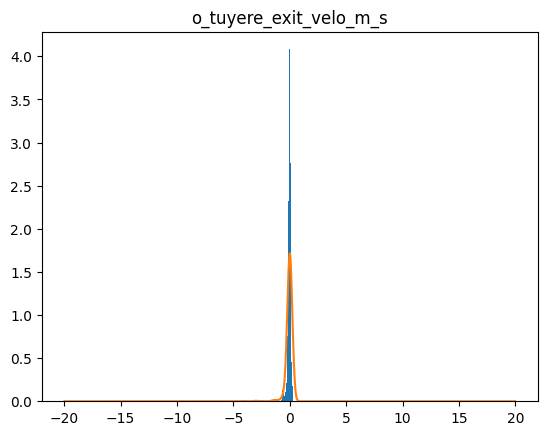

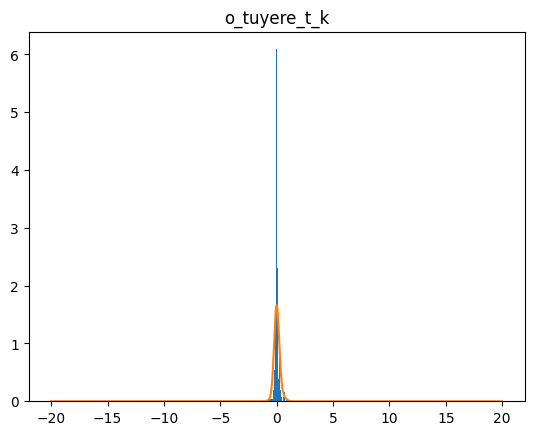

torch.Size([4000])
1351  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1352  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1353  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1354  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1355  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1356  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1357  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1358  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1359  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1360  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1361  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1362  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1363  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1364  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1365  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1366  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1367  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1368  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1369  loss=  tensor(0.0223,

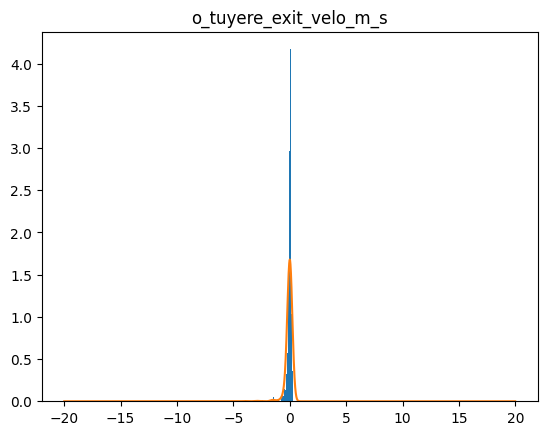

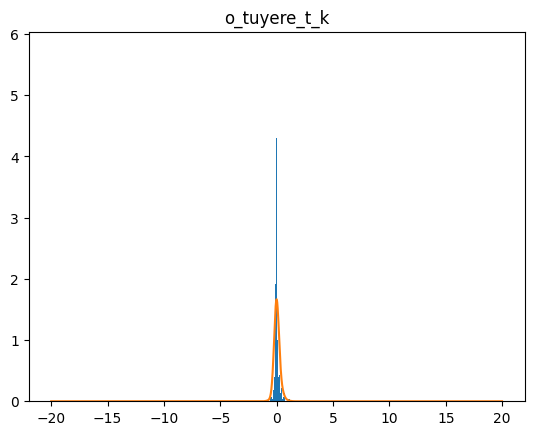

torch.Size([4000])
1401  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1402  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1403  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1404  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1405  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1406  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1407  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1408  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1409  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1410  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1411  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1412  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1413  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1414  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1415  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1416  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1417  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1418  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1419  loss=  tensor(0.0222,

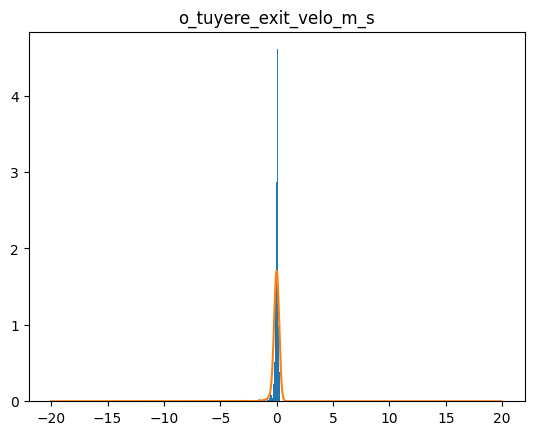

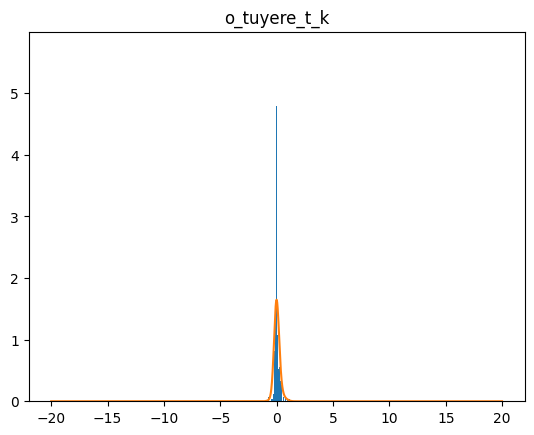

torch.Size([4000])
1451  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1452  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1453  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1454  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1455  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1456  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1457  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1458  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1459  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1460  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1461  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1462  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1463  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1464  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1465  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1466  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1467  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1468  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1469  loss=  tensor(0.0226,

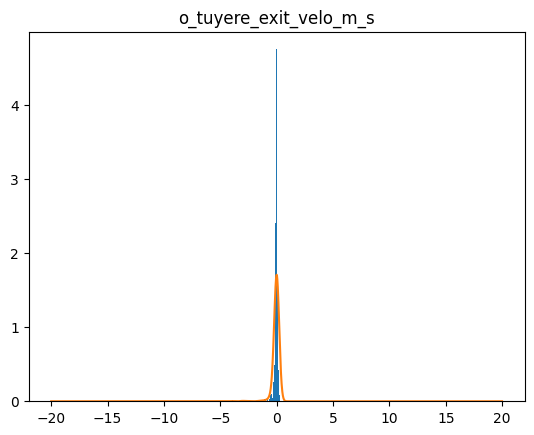

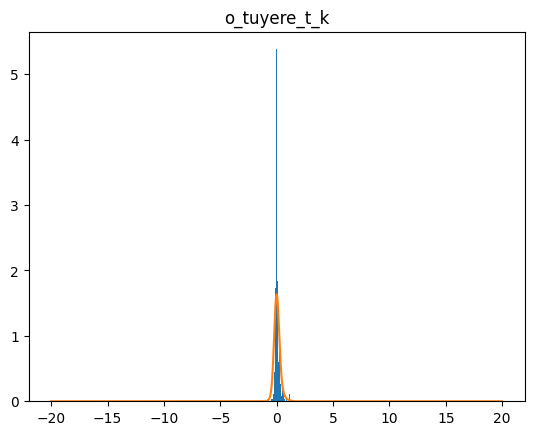

torch.Size([4000])
1501  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1502  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1503  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1504  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1505  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1506  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1507  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1508  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1509  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1510  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1511  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1512  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1513  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1514  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1515  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1516  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1517  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1518  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1519  loss=  tensor(0.0223,

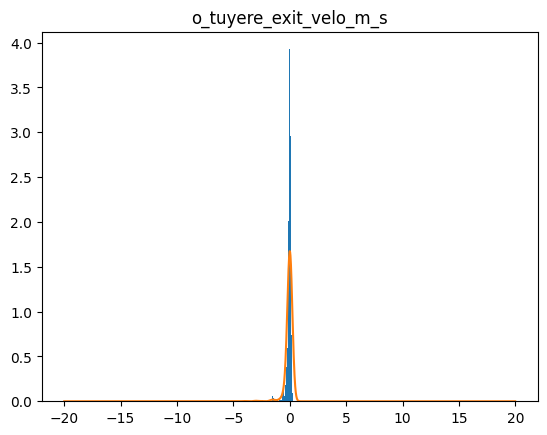

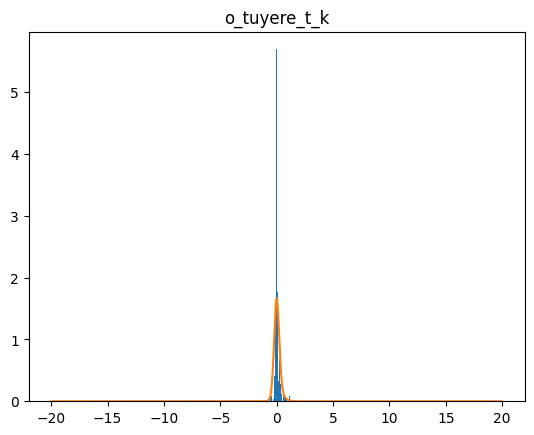

torch.Size([4000])
1551  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1552  loss=  tensor(0.0229, grad_fn=<MeanBackward0>)
1553  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1554  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1555  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1556  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1557  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1558  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1559  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1560  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1561  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1562  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1563  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1564  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1565  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1566  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1567  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1568  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1569  loss=  tensor(0.0226,

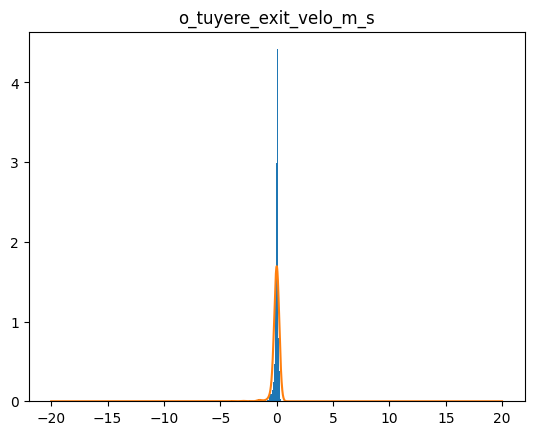

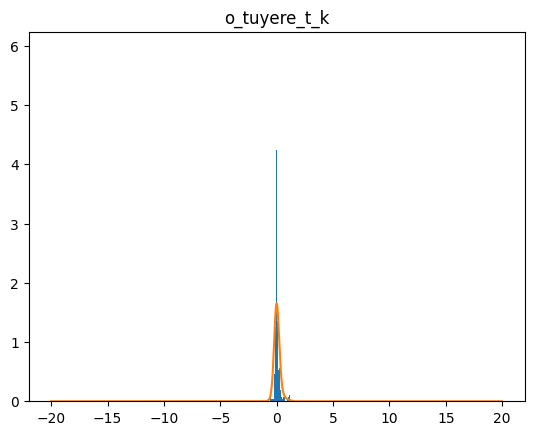

torch.Size([4000])
1601  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1602  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1603  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1604  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1605  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1606  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1607  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1608  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1609  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1610  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1611  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1612  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1613  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1614  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1615  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1616  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1617  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1618  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1619  loss=  tensor(0.0224,

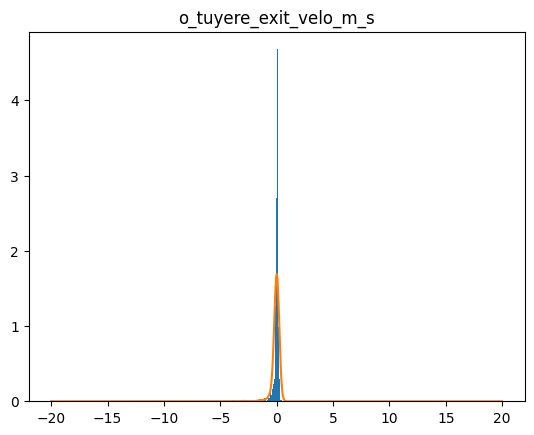

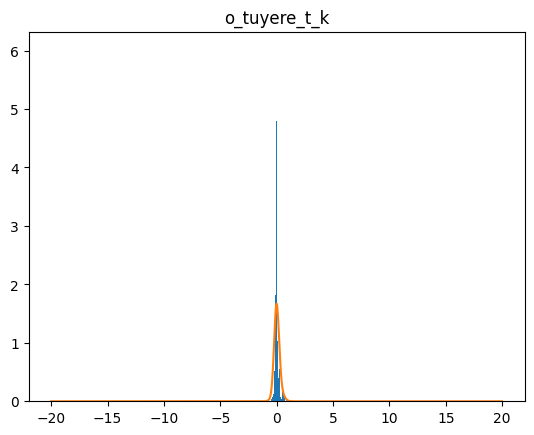

torch.Size([4000])
1651  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1652  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1653  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1654  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1655  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1656  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1657  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1658  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1659  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1660  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1661  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1662  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1663  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1664  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1665  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1666  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1667  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1668  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1669  loss=  tensor(0.0226,

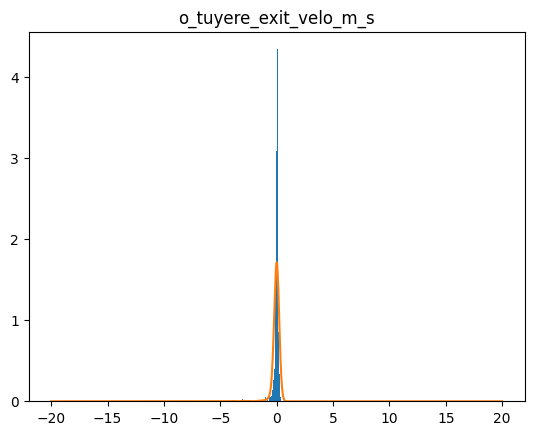

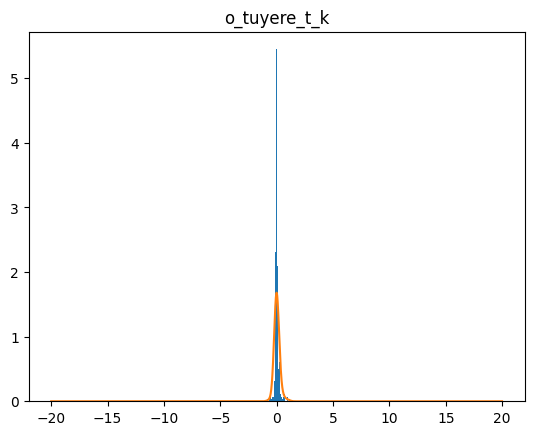

torch.Size([4000])
1701  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1702  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1703  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1704  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1705  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1706  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1707  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1708  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1709  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1710  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1711  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1712  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1713  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1714  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1715  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1716  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1717  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1718  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1719  loss=  tensor(0.0221,

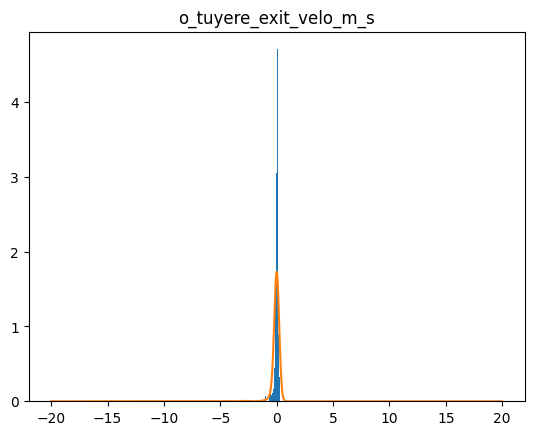

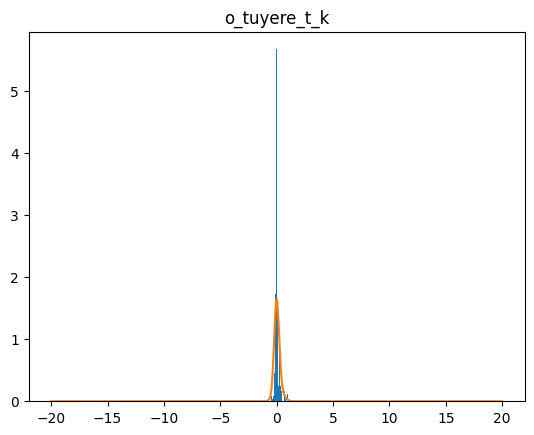

torch.Size([4000])
1751  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1752  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1753  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1754  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1755  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1756  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1757  loss=  tensor(0.0219, grad_fn=<MeanBackward0>)
1758  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1759  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1760  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1761  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1762  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1763  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1764  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1765  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1766  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1767  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1768  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1769  loss=  tensor(0.0223,

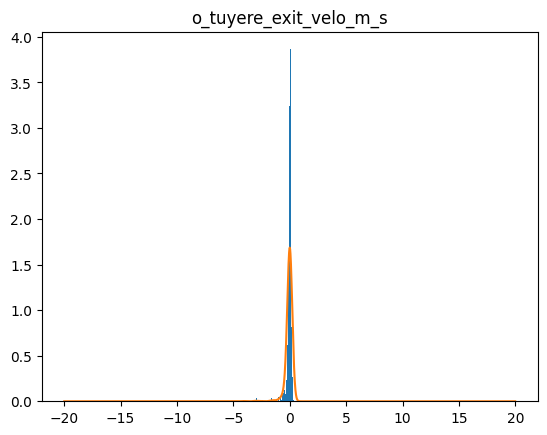

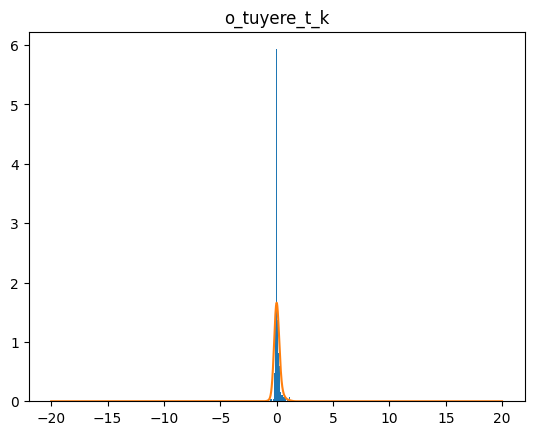

torch.Size([4000])
1801  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1802  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1803  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1804  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1805  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1806  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1807  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1808  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1809  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1810  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1811  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1812  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1813  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1814  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1815  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1816  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1817  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1818  loss=  tensor(0.0218, grad_fn=<MeanBackward0>)
1819  loss=  tensor(0.0225,

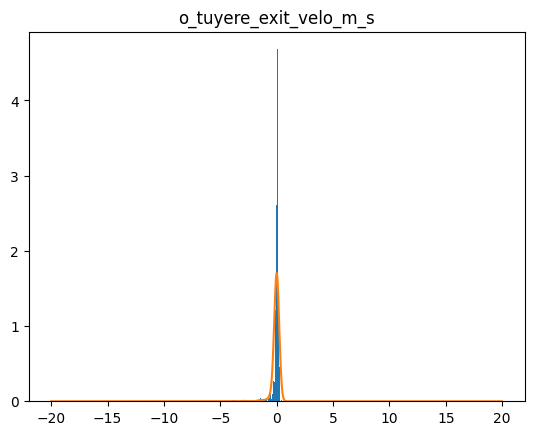

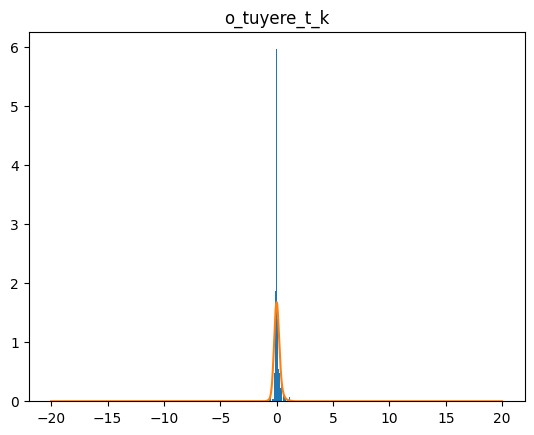

torch.Size([4000])
1851  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1852  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1853  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1854  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1855  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1856  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1857  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1858  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1859  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1860  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1861  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1862  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1863  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1864  loss=  tensor(0.0227, grad_fn=<MeanBackward0>)
1865  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1866  loss=  tensor(0.0226, grad_fn=<MeanBackward0>)
1867  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1868  loss=  tensor(0.0218, grad_fn=<MeanBackward0>)
1869  loss=  tensor(0.0225,

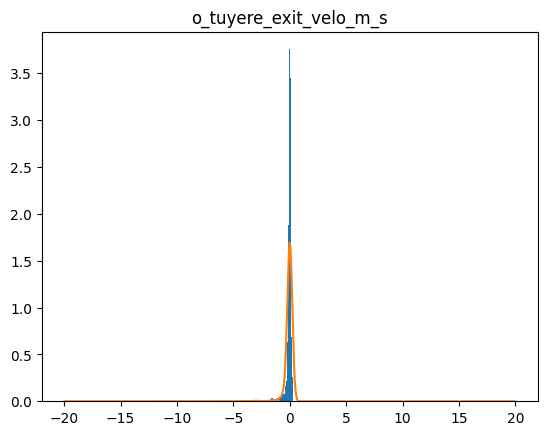

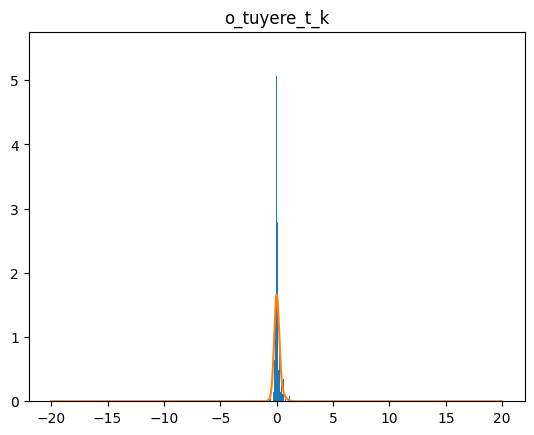

torch.Size([4000])
1901  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1902  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1903  loss=  tensor(0.0228, grad_fn=<MeanBackward0>)
1904  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1905  loss=  tensor(0.0219, grad_fn=<MeanBackward0>)
1906  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1907  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1908  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1909  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1910  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1911  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1912  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1913  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1914  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1915  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1916  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1917  loss=  tensor(0.0218, grad_fn=<MeanBackward0>)
1918  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1919  loss=  tensor(0.0219,

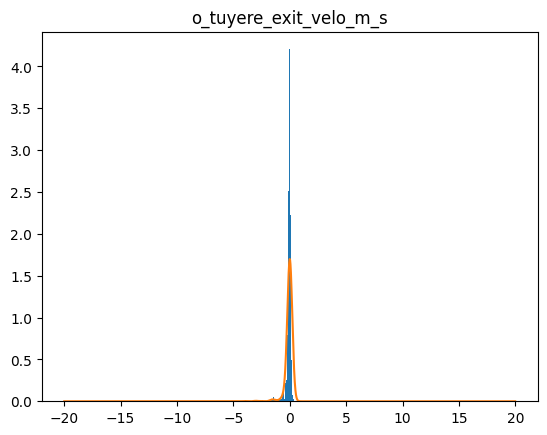

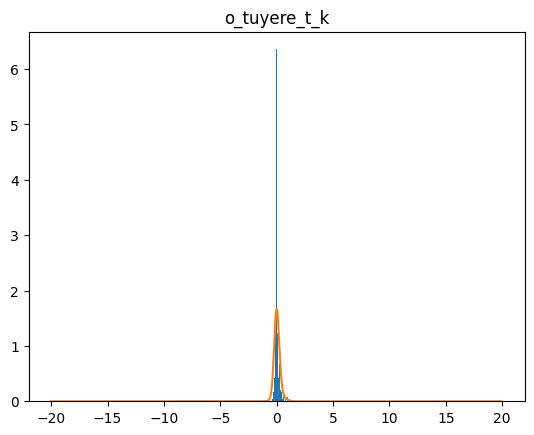

torch.Size([4000])
1951  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1952  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1953  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1954  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1955  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1956  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1957  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1958  loss=  tensor(0.0219, grad_fn=<MeanBackward0>)
1959  loss=  tensor(0.0223, grad_fn=<MeanBackward0>)
1960  loss=  tensor(0.0225, grad_fn=<MeanBackward0>)
1961  loss=  tensor(0.0222, grad_fn=<MeanBackward0>)
1962  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1963  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1964  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1965  loss=  tensor(0.0221, grad_fn=<MeanBackward0>)
1966  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1967  loss=  tensor(0.0220, grad_fn=<MeanBackward0>)
1968  loss=  tensor(0.0224, grad_fn=<MeanBackward0>)
1969  loss=  tensor(0.0224,

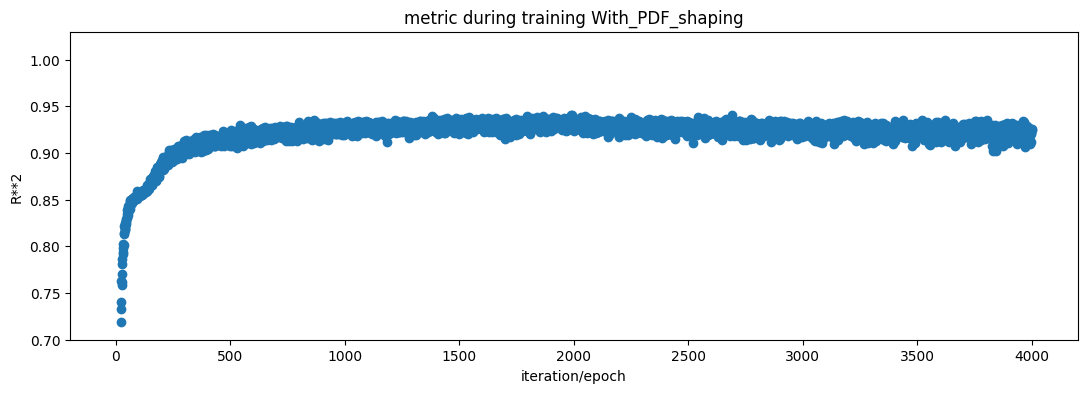

Training loss: tensor(0.0659, grad_fn=<MseLossBackward0>)
Training R**2: 0.9255749879075117
Test loss - scaled: tensor(0.1028, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(18.9418, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9015486905972199
Testing R**2 - descaled: 0.9015486814720819
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.8418230892845454
*****
*****
Testing R**2 - Output: 1 o_tuyere_t_k 0.9612742737016625


In [31]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)



opt         = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [32]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(140.77814, 141.70135)
(1394.567, 1392.966)
**************************************************
preds, real
(143.23294, 143.07054)
(1321.2378, 1321.8584)
**************************************************
preds, real
(132.41173, 132.62503)
(1421.7, 1425.9335)
**************************************************
preds, real
(132.7504, 132.47691)
(1365.918, 1365.9685)
**************************************************
preds, real
(129.76492, 129.80739)
(1422.2941, 1420.4083)
**************************************************
preds, real
(137.63069, 136.86153)
(1432.1438, 1431.8873)
**************************************************
preds, real
(138.20023, 138.02988)
(1424.832, 1423.7987)
**************************************************
preds, real
(139.15732, 139.06866)
(1443.6818, 1444.6963)
**************************************************
preds, real
(136.02496, 135.68008)
(1428.0039, 1427.8629)
***************************

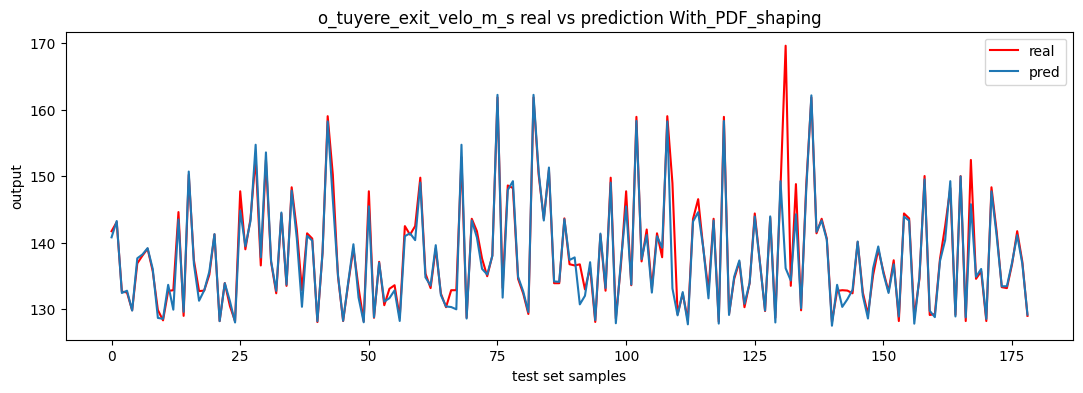

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


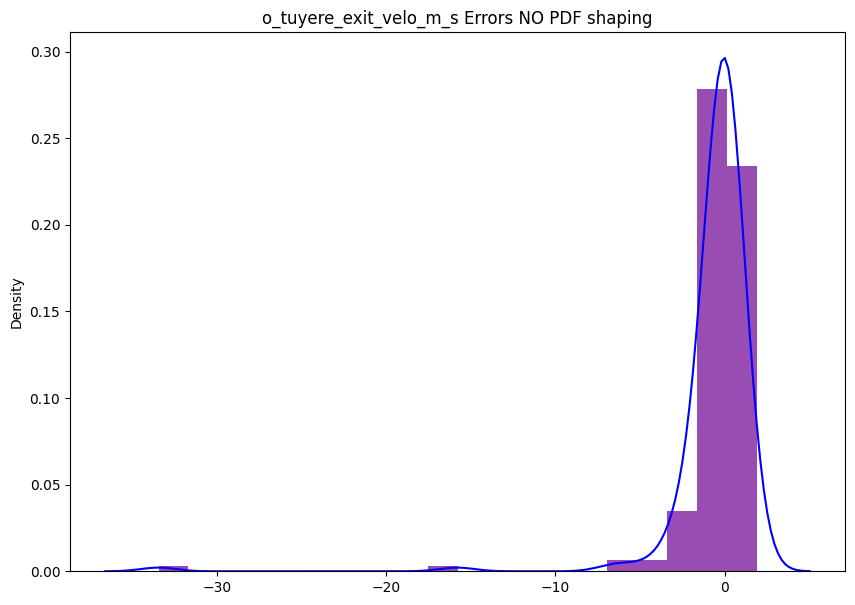

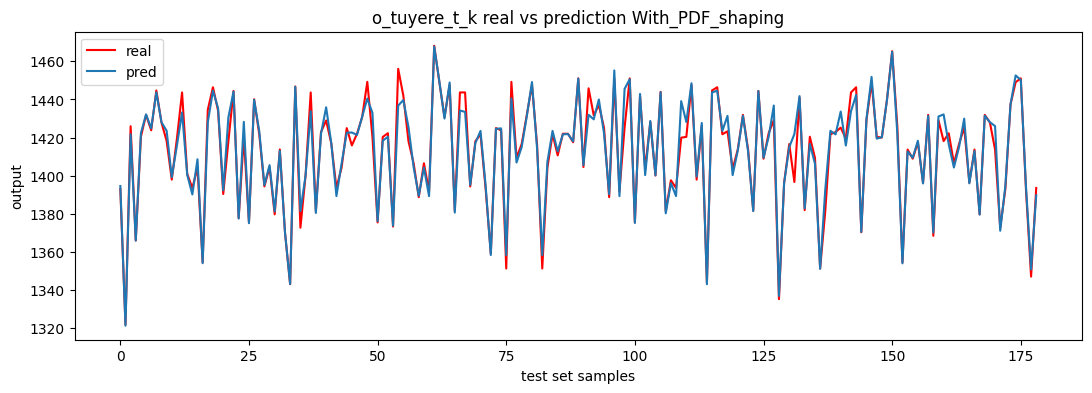

/Users/user/Desktop/DOE_CIVS/experiments/2023may/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


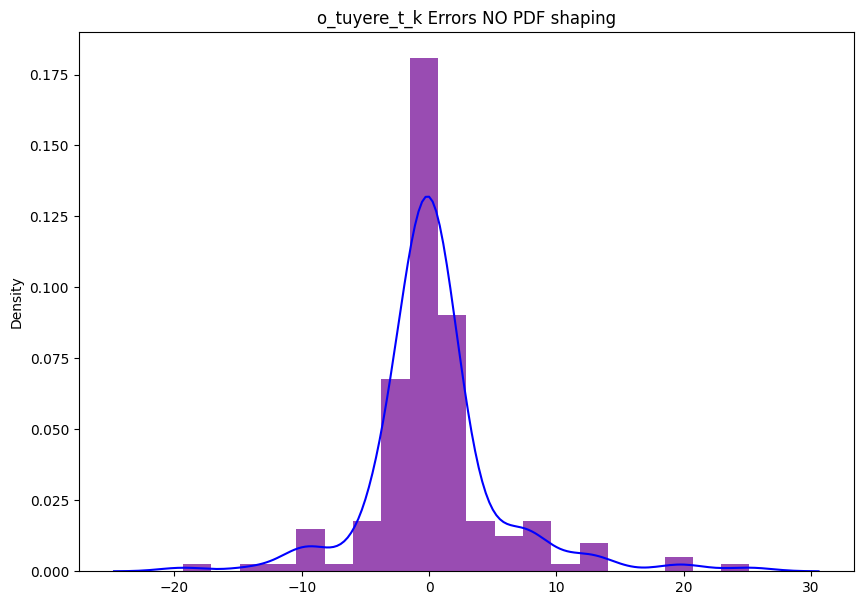

In [33]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## Export ONNX model


In [1]:

'''

model.eval()

dummy_input = torch.randn(1, 5)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''


'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 5)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/s536ShaftPDFshapingRC.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'